In [1]:
%pylab inline
import numpy as np
import tensorflow as tf
from chainconsumer import ChainConsumer
import cmasher as cmr
import jax_cosmo as jc
import jax_cosmo.power as power
import jax_cosmo.transfer as tklib
from scipy.stats import norm
import jax
import matplotlib.colors as colors

Populating the interactive namespace from numpy and matplotlib


### Load data

In [2]:
ps = stack(np.load('/global/homes/d/dlan/DifferentiableHOS/notebooks/summary_files/Cls.npy'), axis=0)
pcounts=stack(np.load('/global/homes/d/dlan/DifferentiableHOS/notebooks/summary_files/Peaks.npy'), axis=0)
ps_jac=stack(np.load('/global/homes/d/dlan/DifferentiableHOS/notebooks/summary_files/jac_cls.npy'), axis=0)
pcounts_jac=stack(np.load('/global/homes/d/dlan/DifferentiableHOS/notebooks/summary_files/jac_peaks.npy'), axis=0)
ell=np.load('/global/homes/d/dlan/DifferentiableHOS/notebooks/summary_files/ell.npy')
ratio=np.load('/global/homes/d/dlan/DifferentiableHOS/notebooks/summary_files/ratio.npy')

##### Compute the mean of the summary 

In [3]:
mups=ps.mean(axis=0)
mupcounts=pcounts.mean(axis=0)

### Computing Fisher matrix

In [4]:

f_sky=25/15_000


cov_ps=np.cov(tf.reshape(ps,[len(ps),11]), rowvar=False)*f_sky
cov_pcounts=np.cov(tf.reshape(pcounts,[len(pcounts),24]), rowvar=False)


dmu_ps = ps_jac.mean(axis=0)
dmu_pcounts = tf.reshape(pcounts_jac,[len(pcounts_jac),24,7]).numpy().mean(axis=0)


Fps = dmu_ps.T @ np.linalg.pinv(cov_ps) @ dmu_ps
Fpcounts = (dmu_pcounts.T @ np.linalg.pinv(cov_pcounts) @ dmu_pcounts)/f_sky



## Add a prior

In [5]:
def compute_prior_matrix(params,params_prior,sigma):
    n = len(params)
    P = np.zeros((n,n))
    for i, param in enumerate(params_prior):
            P[i,i] = 1./sigma[i]**2
    return P

sigma=np.array([0.2,0.14,0.006,0.08,0.063,0.8, 3])
fid_params=np.array([0.2589, 0.8159, 0.04860, 0.9667, 0.6774, -1.0, 0])
P=compute_prior_matrix(fid_params,fid_params,sigma)

# Cls validation against theory 

In [6]:
cosmo=jc.Planck15()
params = np.array([cosmo.Omega_c, cosmo.sigma8, cosmo.Omega_b, cosmo.n_s, cosmo.h, cosmo.w0, 0.0]) 
params_names = ["$\Omega_c$",  "$\sigma_8$", "$\Omega_b$",  "$n_s$", "$h$", "$w0$", "$A_{IA}$"]
cosmo=jc.Planck15()
z = linspace(0,2,1024)
nz=[jc.redshift.kde_nz(z, norm.pdf(z, loc=0.91, scale=0.03), bw=0.03,
                                  gals_per_arcmin2=20., zmax=1.)]

In [7]:
def gaussian_cl_covariance_and_mean(
    cosmo,
    ell,
    probes,
    window=ratio,
    transfer_fn=tklib.Eisenstein_Hu,
    nonlinear_fn=power.halofit,
    f_sky=15_000/41_253,
    sparse=False,
):
    ell = np.atleast_1d(ell)
    n_ell = len(ell)

    # Compute signal vectors
    cl_signal = jc.angular_cl.angular_cl(
        cosmo, ell, probes, transfer_fn=transfer_fn, nonlinear_fn=nonlinear_fn
    )*window
    cl_noise = jc.angular_cl.noise_cl(ell, probes)*window
    cov_mat =  jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky, sparse)

    return cl_signal.flatten(), cov_mat

probes=[ jc.probes.WeakLensing(nz)]
mu, cov= gaussian_cl_covariance_and_mean(cosmo, ell, probes)


/global/homes/d/dlan/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [8]:
@jax.jit
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1],Omega_b=p[2],n_s=p[3],h=p[4],w0=p[5])
  # Compute signal vector
  probes = [ jc.probes.WeakLensing(nz, sigma_e=0.26, ia_bias=[jc.bias.constant_linear_bias(p[6])])]
  m = jc.angular_cl.angular_cl(cosmo,ell, probes,)*ratio
  return m.flatten() # We want it in 1d to operate against the covariance matrix
jac_mean = jax.jit(jax.jacfwd(mean_fn))
dmu = jac_mean(params)

In [9]:
F = dmu.to_py().T @ np.linalg.inv(cov.to_py()) @ dmu.to_py() 


### Look at the derivatives

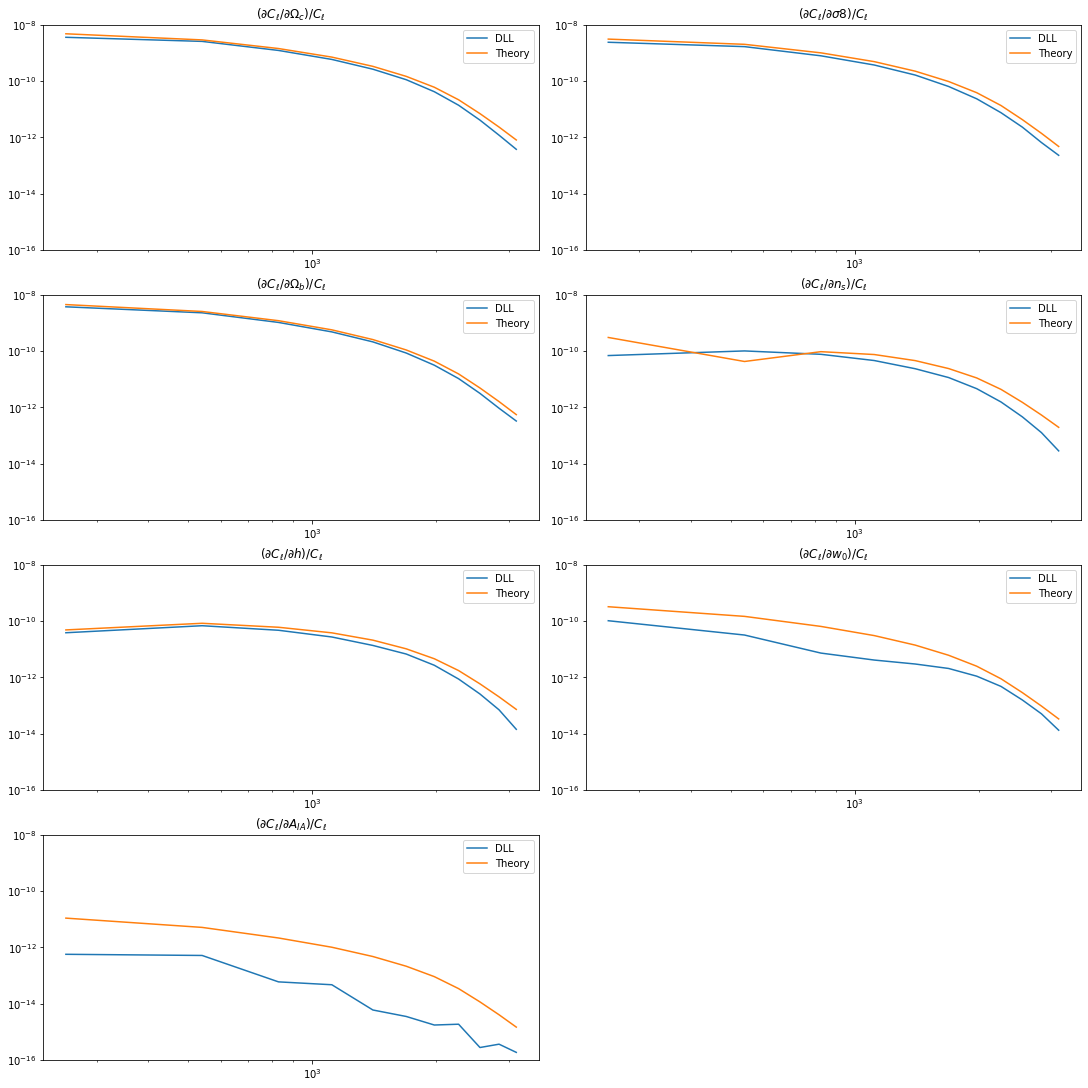

In [10]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$","$A_{IA}$"]
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =4
ax = fig.subplots(rows, cols)
for j in range(7):
    ax.flatten()[j].loglog(ell,abs(ps_jac[:,:,:].mean(axis=0)[...,j]),label='DLL')
    ax.flatten()[j].loglog(ell,abs(dmu[:,j]),label='Theory')
    ax.flatten()[j].set_title('$(\partial C_\ell/\partial$' +str(labels[j])+'$)/C_{\ell}$')
    ax.flatten()[j].set_ylim(1e-16,1e-8)
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #ax.flatten()[j].label_outer()
for i in range(7,8):
    ax.flatten()[i].remove()

### Fisher contours 

/global/homes/d/dlan/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/chainconsumer/chainconsumer.py:346: RuntimeWarning: covariance is not positive-semidefinite.
  chain = np.random.multivariate_normal(mean, covariance, size=1000000)


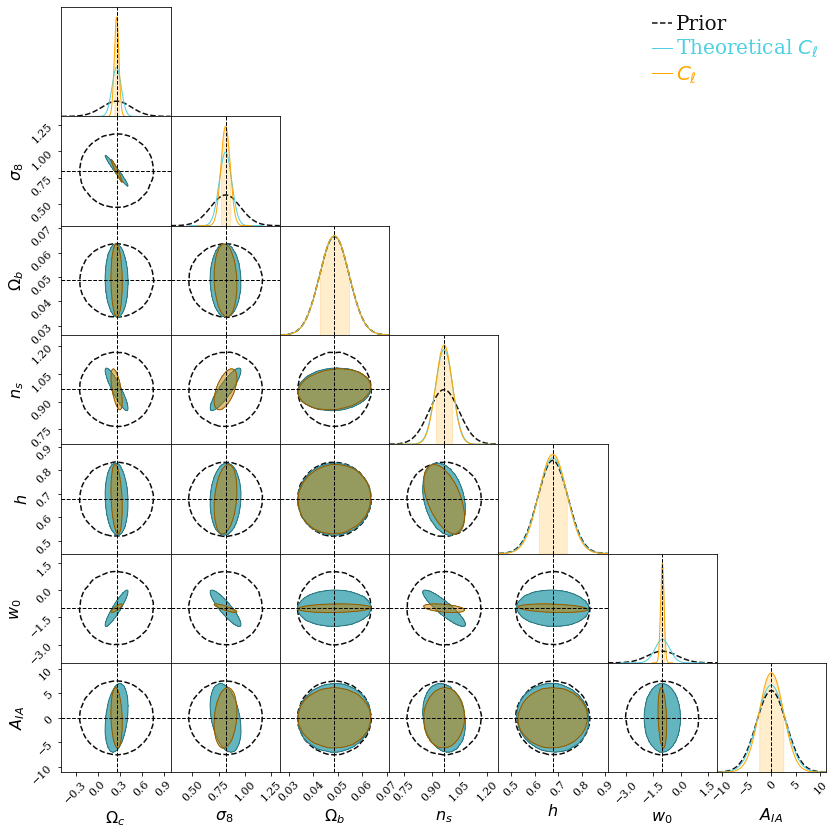

In [11]:
c_val = ChainConsumer()
c_val.add_covariance(fid_params,  np.linalg.pinv(P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="Prior")
c_val.add_covariance(fid_params , np.linalg.pinv(F+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="Theoretical $C_{\ell}$")

c_val.add_covariance(fid_params,  np.linalg.pinv(Fps+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="$C_{\ell}$")

c_val.configure(usetex=False,legend_kwargs={'fontsize': 20},linewidths=[1.5, 1., 1.0], shade=[False, True, True],linestyles=["--", "-", "-"], shade_alpha=[0.0,0.8, 0.5], bar_shade=[False,False,True], tick_font_size=11, colors=["#111111", "cyan","#FFA500" ], label_font_size=16,sigmas=[0,2],sigma2d=False)
fig = c_val.plotter.plot(truth=fid_params)
fig.set_size_inches(2 + fig.get_size_inches())
#plt.savefig('../figures/Fisher_IA_theory.pdf')


# Fisher comparison

In [12]:
col = cmr.eclipse([0.,0,0.55,0.85]) 

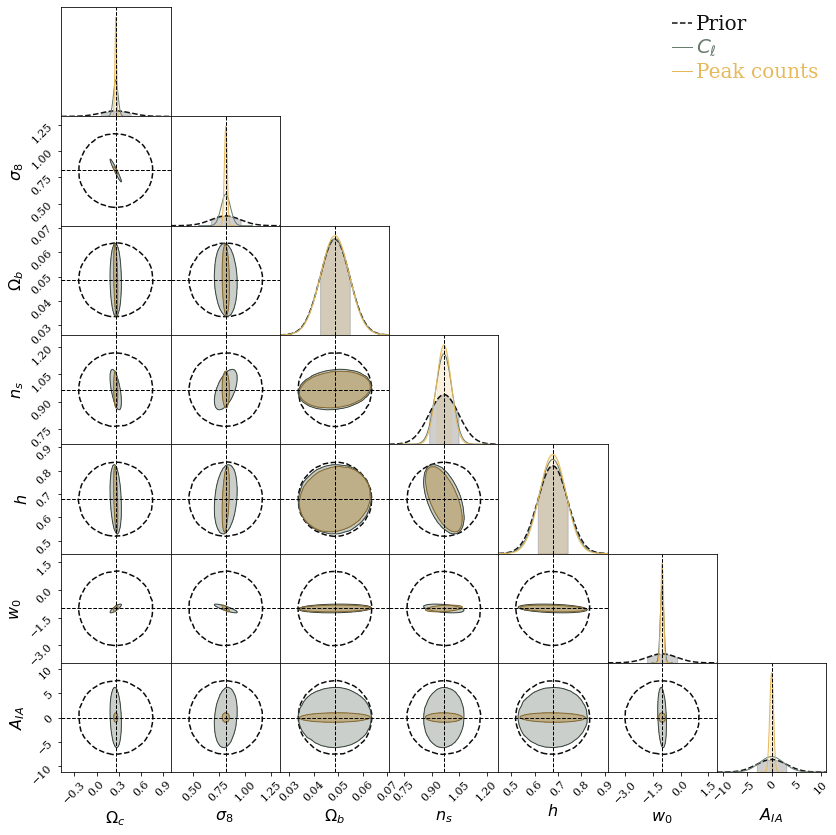

In [13]:
c_val = ChainConsumer()
c_val.add_covariance(fid_params,  np.linalg.pinv(P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="Prior")
c_val.add_covariance(fid_params,  np.linalg.pinv(Fps+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="$C_{\ell}$")
c_val.add_covariance(fid_params , np.linalg.pinv(Fpcounts+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="Peak counts")
c_val.configure(usetex=False,legend_kwargs={'fontsize': 20},linewidths=[1.5, 1., 1.0], shade=[False, True, True],linestyles=["--", "-", "-"], shade_alpha=[0.0,0.3, 0.5], bar_shade=[True,False,True], tick_font_size=11, colors=["#111111",col[2],col[3]], label_font_size=16,sigmas=[0,2],sigma2d=False)
fig = c_val.plotter.plot(truth=fid_params)
fig.set_size_inches(2 + fig.get_size_inches())


### Rescaling the covariance with the Hartlap factor

In [17]:
inv_cov_ps_har=((5_000-11-2)/(5_000-1))*np.linalg.pinv(cov_ps,rcond=1e-9)
inv_cov_pcounts_har=((5_000-24-2)/(5_000-1))*np.linalg.pinv(cov_pcounts,rcond=1e-9)
Fps_har= dmu_ps.T @ inv_cov_ps_har @ dmu_ps
Fpcounts_har = dmu_pcounts.T @ inv_cov_pcounts_har @ dmu_pcounts/f_sky

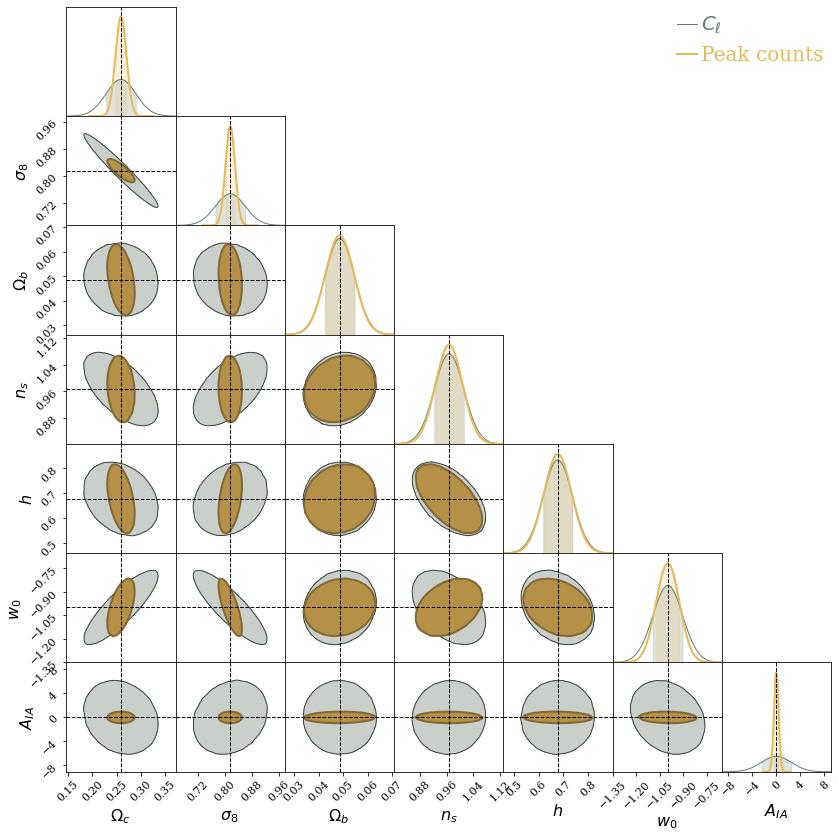

In [18]:
c_val = ChainConsumer()
c_val.add_covariance(fid_params,  np.linalg.pinv(Fps_har+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="$C_{\ell}$")
c_val.add_covariance(fid_params , np.linalg.pinv(Fpcounts_har+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="Peak counts")
c_val.configure(usetex=False,legend_kwargs={'fontsize': 20},linewidths=[ 1., 2.0], shade=[True, True],linestyles=[ "-", "-"], shade_alpha=[0.3, 1], bar_shade=[True,True], tick_font_size=11, colors=[col[2],col[3]], label_font_size=16,sigmas=[0,2],sigma2d=False)
fig = c_val.plotter.plot(truth=fid_params)
fig.set_size_inches(2 + fig.get_size_inches())
plt.savefig('../figures/Fisher.pdf')


## Final results

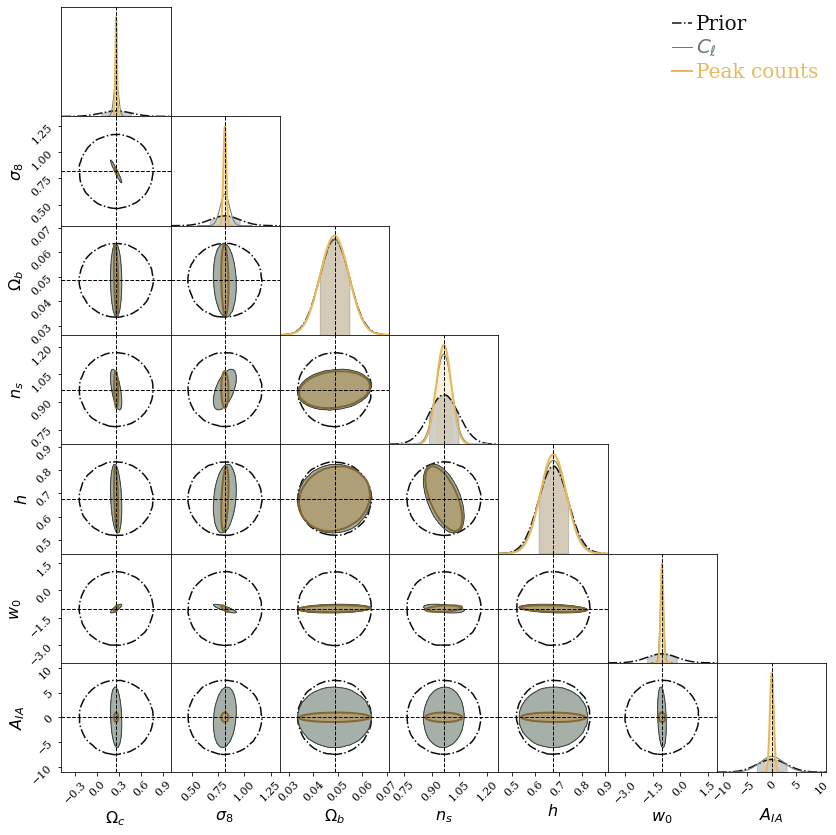

In [19]:
c_val = ChainConsumer()
c_val.add_covariance(fid_params,  np.linalg.pinv(P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="Prior")
c_val.add_covariance(fid_params,  np.linalg.pinv(Fps_har+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="$C_{\ell}$")
c_val.add_covariance(fid_params , np.linalg.pinv(Fpcounts_har+P,rcond=1e-14), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$", "$A_{IA}$"], name="Peak counts")
c_val.configure(usetex=False,legend_kwargs={'fontsize': 20},linewidths=[1.5, 1., 2.0], shade=[False, True, True],linestyles=["-.", "-", "-"], shade_alpha=[0.0,0.5, 0.5], bar_shade=[True,False,True], tick_font_size=11, colors=["#111111",col[2],col[3]], label_font_size=16,sigmas=[0,2],sigma2d=False)
fig = c_val.plotter.plot(truth=fid_params)
fig.set_size_inches(2 + fig.get_size_inches())
plt.savefig('../figures/Fisher_prior.pdf')
